In [128]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
st = tf.contrib.bayesflow.stochastic_tensor

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [129]:
batch_size = 40
ns = 1
lr = 1e-3
eps = 1e-7
alpha = 0.9
PD = False

In [130]:
def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
            b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def sample(p):
    return st.StochasticTensor(dist=Bernoulli(probs=p, dtype=tf.float32),
                               dist_value_type=st.SampleValue()).value()

def prob(p, s):
    return s*p + (1.0-s)*(1.0-p)

In [131]:
x = tf.placeholder(tf.float32, [None, 392])
yy = tf.placeholder(tf.float32, [None, 392])
y_ = tf.tile(yy, [ns, 1])

h = tf.tile(tf.clip_by_value(add_layer(x, "wxh", "bxh", 392, 200, tf.nn.sigmoid), eps, 1.0-eps), [ns, 1])
if PD is False:
    sh = tf.stop_gradient(sample(h))
else:
    sh = tf.stop_gradient(sample(h)-h)+h
y = tf.clip_by_value(add_layer(sh, "why", "bhy", 200, 392, tf.nn.sigmoid), eps, 1.0-eps)
    
y = prob(y, y_)
y_sum = tf.reduce_sum(tf.reshape(y, [ns, batch_size, 392]), 0)
y_expect = tf.clip_by_value(y_sum/ns, eps, 1.0-eps)

nll = tf.reduce_mean(tf.reduce_sum(-tf.log(y_expect), 1))
loss = tf.reduce_sum(-tf.log(y), 1, keep_dims=True) / ns

saver = tf.train.Saver()

In [137]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)

def LR(md):
    func = {
        0: lambda: [loss]+[tf.constant(0.)]*4,
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL,
    }
    ls, mu, tr, m, v = func.get(md)()
    loss_h = tf.reduce_mean(tf.reduce_sum(tf.stop_gradient(ls)*tf.log(prob(h, sh)) + mu, 1))
    train_step = tf.train.AdamOptimizer(lr).minimize(nll+loss_h+tr)
    return train_step, nll, m, v

def baseline():
    b = alpha*bsln + (1.0-alpha)*nll
    return loss-b, 0., 0., b, tf.constant(0.)

def muProp():
    ch = tf.clip_by_value(add_layer(h, "why", "bhy", 200, 392, tf.nn.sigmoid), eps, 1.0-eps)
    loss_ch = tf.reduce_sum(-tf.log(prob(ch, y_)), 1, keep_dims=True)
    dh = tf.gradients(loss_ch, h)[0]
    return loss-loss_ch-tf.reduce_sum(dh*(sh-h),1,keep_dims=True), tf.stop_gradient(dh)*h, 0., tf.constant(0.), tf.constant(0.)
        
def DARN():
    dh = tf.gradients(loss, sh)[0]
    return dh*(sh-0.5), 0., 0., tf.constant(0.), tf.constant(0.)

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-tf.reduce_mean((loss-cy))))*ns/tf.maximum(1.0, ns-1)
    v = alpha*bslnv + (1.0-alpha)*vv
    return (loss-cy-b)/tf.maximum(1.0,tf.sqrt(v)), 0., tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [138]:
def train(train_op):
    with tf.Session() as sess:
        bl = 0.
        vr = 0.
        ll = []
        t = 0.
        sess.run(tf.global_variables_initializer())

        for i in range(50000):
            batch_ = data.next_batch(batch_size)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, yy: batch_ys, bsln: bl, bslnv: vr})
            bl = res[2]
            vr = res[3]
            
            t += res[1]
            if (i+1)%1000==0:
                t /= 1000
                ll.append(t)
                print i/1000, t,
                t = 0.
                
       # save_path = saver.save(sess, "model/model.ckpt")
    return ll

In [139]:
#train_op = ST_()
train_op = LR(4)
nv = train(train_op)

0 352.374946442 1 206.952635986 2 164.061062744 3 137.196864418 4 118.499370453 5 105.512537575 6 97.2381313248 7 91.8811565933 8 88.3771812515 9 86.0626764069 10 84.4036172791 11 83.1968920517 12 82.1555700531 13 81.3439987106 14 80.6318422318 15 80.2104698677 16 79.7296213379 17 79.1897517166 18 78.7165246544 19 78.522182251 20 78.0970272751 21 77.7401103287 22 77.3937477798 23 77.1512450104 24 76.8322091103 25 76.6244315262 26 76.4037404442 27 76.1512595787 28 75.9970048065 29 75.7274572563 30 75.4169388695 31 75.2024846268 32 75.0478493004 33 74.8484517899 34 74.6571991577 35 74.4900639267 36 74.4704264374 37 74.0820215149 38 73.9035241547 39 73.7681795235 40 73.5228906898 41 73.3476147079 42 73.2456052208 43 73.1416236191 44 72.9341568832 45 72.7296318245 46 72.5975943146 47 72.4609344025 48 72.3593904762 49 72.1639881096


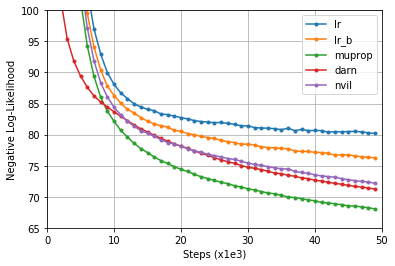

In [144]:
fig = plt.figure()
ax = plt.subplot(111)
plt.xlim(0, 50)
plt.ylim(65, 100)

#1 hl
ax.plot(lhr, '.-',label="lr")
ax.plot(lhrb, '.-',label="lr_b")
ax.plot(mp, '.-', label="muprop")
ax.plot(dn, '.-', label="darn")
ax.plot(nv, '.-', label="nvil")

plt.legend()
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
plt.grid()
plt.show()
#fig.savefig('foo.png')